# Projeto Final de Ciência dos Dados. ( PkmnID)

## Algoritmo de predição da categoria de Pokémons por meio de suas imagens.
### O algoritmo realiza a extração e a clusterização de features de imagens por meio do método \"Bag of Visual Words\" (BOVW),classifica-as utilizando o método de machine learning \"Random Forest\" e prevê a categoria de Pokémons por meio de novas imagens.

In [39]:
!pip install opencv-contrib-python
import cv2
import os
import os.path
import numpy as np
import math
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

np.random.seed(0)

TRAIN_DIR = 'Assets//Data_Train'
TEST_DIR = 'Assets//Data_Test'
CLASSES = os.listdir(TRAIN_DIR)

NUM_CLUSTERS = 40

In [40]:
## Máquina de controle:

# Re-adquiri as features das imagens.
READ_IMAGES = 0

# Cria arquivo Json para dicionário de Features.
UPDATE_FILES = 0

# Constrói dataframe com dados do dicionário de features.
CREATE_FEATURE_DATAFRAME = 1

# Mostra em quais 'n' pokémons, cada feature é mais proeminente.
SHOW_TOP_N_FOR_FEATURES = 1

# Re-treina os models.
FIT_MODELS = 1

# Produz matrizes de confusão para todos os modelos.
PLOT_CONFUSION_MATRIXES = 1

# Produz uma lista com a métrica precision@n para todos os modelos.
PRECISION_AT_N = 1


## 1- Extração de features de imagens: Bag of Visual Words
### Uma vez que o dataset se trata de um conjunto de imagens de diferentes Pokémons, é necessário inicialmente extrair features dessas imagens, através do método "Bag of Visual Words".
### Com as imagens transformadas em features clusterizadas, elas são separadas em categorias de treino e teste, que serão utilizadas posteriormente pelo algoritmo de machine learning.
### O código abaixo realiza essas duas etapas:
#### Obs: Código produzido com a assistência do Prof. Fábio Ayres

In [41]:
def get_img_names(TRAIN_DIR = TRAIN_DIR, TEST_DIR = TEST_DIR):

    TRAIN_IMG = []
    TEST_IMG = []
    TRAIN_LABEL = []
    TEST_LABEL = []

    for train, test in zip(os.listdir(TRAIN_DIR), os.listdir(TEST_DIR)): #Tecnicamente são iguais, mas não custa garantir.
        for img_train, img_test in zip(os.listdir(os.path.join(TRAIN_DIR,train)), os.listdir(os.path.join(TEST_DIR,test))):
            TRAIN_IMG.append(os.path.join(TRAIN_DIR,train,img_train))
            TEST_IMG.append(os.path.join(TEST_DIR,test,img_test))
            TRAIN_LABEL.append(train)
            TEST_LABEL.append(test)

    return TRAIN_IMG, TEST_IMG, TRAIN_LABEL, TEST_LABEL

def cria_vocabulario(imagens, num_clusters):
    km = cv2.BOWKMeansTrainer(num_clusters)
    akaze = cv2.KAZE_create()
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        mask = np.ones(img.shape)
        kp, desc = akaze.detectAndCompute(img, mask)
        km.add(desc)
    return km.cluster()

def representa(vocab, img):
    kaze = cv2.KAZE_create()
    kp = kaze.detect(img)
    bowdesc = cv2.BOWImgDescriptorExtractor(kaze, cv2.FlannBasedMatcher())
    bowdesc.setVocabulary(vocab)
    return bowdesc.compute(img, kp)

def transforma_imagens(imagens, vocab):
    X = []
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        X.append(representa(vocab, img).flatten())
    return np.array(X)

def show_example(path = os.listdir("Testes/Testes/")[0], plot = True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, dsize=(120, 120))
    if Plot:
        plt.imshow(img_resized, cmap='gray', vmin=0, vmax=255)
    return representa(vocab, img_resized)

In [42]:
Hist_Dict = {}
Test_Dict = {}
TRAIN_IMG, TEST_IMG, TRAIN_LABEL, TEST_LABEL = get_img_names()

if READ_IMAGES:       
    vocab = cria_vocabulario(TRAIN_IMG, NUM_CLUSTERS)
    for pkmn in os.listdir(TRAIN_DIR):
        Hist_Dict[pkmn] = transforma_imagens([os.path.join(TRAIN_DIR, pkmn, n) for n in os.listdir(os.path.join(TRAIN_DIR,pkmn))], vocab) 
    for pkmn in os.listdir(TEST_DIR):
        Test_Dict[pkmn] = transforma_imagens([os.path.join(TEST_DIR, pkmn, n) for n in os.listdir(os.path.join(TEST_DIR,pkmn))], vocab)
    
    
    if UPDATE_FILES:
        np.save('Features_Train', Hist_Dict)
        np.save('Features_Test', Test_Dict)
        np.save('Bag_of_Visual_Words', vocab)
            

else:
        Hist_Dict = np.load('Features_Train.npy', allow_pickle=True)[()]
        Test_Dict = np.load('Features_Test.npy', allow_pickle=True)[()]
        vocab = np.load('Bag_of_Visual_Words.npy', allow_pickle=True)[()]

In [43]:
X_train_vectors = np.array([v for k,v in Hist_Dict.items()]) 
X_test_vectors = np.array([v for k,v in Test_Dict.items()]) 
y_train_vectors = [] 
y_test_vectors = []

for k in Hist_Dict:
    x = []
    for v in Hist_Dict[k]:
        x.append(k)
    x = np.array(x)
    y_train_vectors.append(x)


for k in Test_Dict:
    x2 = []
    for v in Test_Dict[k]:
        x2.append(k)
    x2 = np.array(x2)
    y_test_vectors.append(x2)

y_train_vectors = np.array(y_train_vectors)
y_test_vectors = np.array(y_test_vectors)

X_train, X_test, y_train, y_test = [], [], [], []
for pkmn, matrix in zip(CLASSES, X_train_vectors):
    for feature_vector in matrix:
        X_train.append(feature_vector)
        y_train.append(pkmn)

for pkmn_test, matrix_test in zip(CLASSES, X_test_vectors):
    for feature_vector_test in matrix_test:
        X_test.append(feature_vector_test)
        y_test.append(pkmn_test)

## 2 - Análise Exploratória:
### Para realizar a análise exploratória seguiremos alguns passos:

## 2.2 - Criar um dataframe para trabalhar melhor com o dataset:

In [44]:
if CREATE_FEATURE_DATAFRAME:    
    lista = []
    lista_nomes = os.listdir('Assets/Data_Train')
    for k in Hist_Dict:
        mean = []
        for i in range(NUM_CLUSTERS):
            mean.append(pd.Series(Hist_Dict[k][:,i]).mean())
        lista.append(mean)
    df_medias = pd.DataFrame(lista, index = lista_nomes)
else:
    df_medias = pd.DataFrame([[1],[1]])

## Tabela das frequências relativas médias de cada feature por pokémon:

In [45]:
df_medias

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Aerodactyl,0.017512,0.045390,0.039530,0.006369,0.018837,0.057043,0.027858,0.014854,0.003807,0.003461,...,0.022604,0.032373,0.004447,0.010665,0.022807,0.013150,0.057155,0.023127,0.027539,0.013103
Alakazam,0.019577,0.028594,0.043415,0.009204,0.009999,0.024741,0.014269,0.014719,0.009716,0.009321,...,0.039217,0.047838,0.004881,0.013332,0.031779,0.013664,0.049751,0.034298,0.014349,0.016512
Arbok,0.020128,0.011093,0.020466,0.011155,0.010373,0.018590,0.054345,0.019689,0.016710,0.019366,...,0.021548,0.026841,0.012743,0.015349,0.034676,0.017008,0.035070,0.033584,0.033250,0.019261
Arcanine,0.011510,0.019285,0.052780,0.011732,0.025967,0.010599,0.034579,0.016313,0.008718,0.014446,...,0.052810,0.045125,0.008201,0.009533,0.032117,0.012895,0.019160,0.033219,0.038148,0.008685
Beedrill,0.011578,0.024495,0.067367,0.005781,0.024571,0.038992,0.015572,0.012899,0.003544,0.006759,...,0.052004,0.046640,0.003756,0.005803,0.024761,0.010655,0.024467,0.024795,0.022497,0.007999
Bellsprout,0.014761,0.012970,0.095314,0.012951,0.011204,0.017004,0.020428,0.010746,0.006804,0.010263,...,0.065315,0.065907,0.005306,0.006901,0.036410,0.005386,0.018445,0.017616,0.016895,0.018213
Bulbasaur,0.019233,0.023417,0.023329,0.018935,0.036664,0.005742,0.059155,0.028253,0.016721,0.017913,...,0.024709,0.023080,0.008730,0.029389,0.021144,0.024933,0.014675,0.025713,0.033729,0.018795
Charmander,0.019570,0.025452,0.036732,0.009630,0.036208,0.025569,0.036344,0.028595,0.005629,0.010760,...,0.040983,0.033977,0.006196,0.016119,0.037936,0.018733,0.025084,0.020535,0.038533,0.015894
Jigglypuff,0.011555,0.010638,0.047818,0.010309,0.029119,0.011171,0.025152,0.018894,0.008693,0.014083,...,0.106576,0.031358,0.006980,0.011477,0.020567,0.020626,0.010160,0.013980,0.035890,0.008802
Meowth,0.012432,0.024601,0.043866,0.008871,0.032222,0.016563,0.014152,0.024336,0.006244,0.017936,...,0.051101,0.046946,0.007855,0.012965,0.035471,0.007445,0.020129,0.021557,0.023754,0.010569


## 2.3 - Calculando os valores médios dos dados:
### Nesta etapa foi calculado os valores médios dos dados, e em sequência foram aproximados do ponto (0,0), origem do sistema.

In [46]:
df_medias = df_medias - (1/40)

In [47]:
df_medias.sum(axis=1)

Aerodactyl    1.310837e-07
Alakazam      1.951121e-07
Arbok         2.495944e-07
Arcanine      1.606531e-07
Beedrill      1.282897e-07
Bellsprout   -5.401671e-08
Bulbasaur    -2.235174e-08
Charmander    4.051253e-08
Jigglypuff   -8.102506e-08
Meowth        9.778887e-08
Pidgey       -1.909211e-08
Squirtle     -6.286427e-08
Voltorb       8.055940e-08
dtype: float64

In [48]:
normas = (df_medias*df_medias).sum(axis=1)
for m in normas.index:
    df_medias.loc[m] = df_medias.loc[m]/np.sqrt(normas[m])

## 2.4 - Comparação entre os Pokémons:
### Com base nos valores calculados anteriormente, foi criada a tabela seguinte, que mostra o quanto os Pokémons são semelhantes entre si, sendo 1 a semelhança máxima, e -1 o oposto.

In [49]:
df_compara = df_medias.dot(df_medias.transpose())
df_compara

,Aerodactyl,Alakazam,Arbok,Arcanine,Beedrill,Bellsprout,Bulbasaur,Charmander,Jigglypuff,Meowth,Pidgey,Squirtle,Voltorb
Aerodactyl,1.000000,0.662392,0.075888,0.332698,0.658928,0.363447,-0.129495,0.413867,0.116037,0.449233,0.445630,0.251118,0.323563
Alakazam,0.662392,1.000000,0.281138,0.749945,0.802121,0.675984,0.135231,0.436772,0.470495,0.811202,0.520998,0.548312,0.018211
Arbok,0.075888,0.281138,1.000000,0.441913,0.205085,0.168807,0.627830,0.375706,0.235465,0.194558,0.194604,0.526647,0.539323
Arcanine,0.332698,0.749945,0.441913,1.000000,0.827409,0.838483,0.448226,0.726273,0.807215,0.889797,0.819202,0.901001,0.045021
Beedrill,0.658928,0.802121,0.205085,0.827409,1.000000,0.798300,0.142020,0.677849,0.639219,0.865709,0.834361,0.708631,0.147347
Bellsprout,0.363447,0.675984,0.168807,0.838483,0.798300,1.000000,0.085352,0.602334,0.712607,0.797042,0.751444,0.704292,-0.013030
Bulbasaur,-0.129495,0.135231,0.627830,0.448226,0.142020,0.085352,1.000000,0.525862,0.445060,0.300900,0.298708,0.595461,0.377624
Charmander,0.413867,0.436772,0.375706,0.726273,0.677849,0.602334,0.525862,1.000000,0.697519,0.718059,0.892793,0.876390,0.415990
Jigglypuff,0.116037,0.470495,0.235465,0.807215,0.639219,0.712607,0.445060,0.697519,1.000000,0.751049,0.716191,0.773686,0.087475
Meowth,0.449233,0.811202,0.194558,0.889797,0.865709,0.797042,0.300900,0.718059,0.751049,1.000000,0.809986,0.792760,-0.003531


### Podemos observar que alguns Pokémons possuem muitas semelhanças pois apresentam as mesmas features em abundância (na média)."

In [50]:
if SHOW_TOP_N_FOR_FEATURES:    
    monstros = []
    for feat in range(NUM_CLUSTERS):
        monstros.append(sorted(df_medias.nlargest(n=5, columns=[feat]).index) + [feat])
    x = sorted(monstros)
    pprint(x)

[['Aerodactyl', 'Alakazam', 'Arbok', 'Bulbasaur', 'Voltorb', 0],
 ['Aerodactyl', 'Alakazam', 'Arbok', 'Charmander', 'Voltorb', 36],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Bulbasaur', 'Pidgey', 19],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Voltorb', 5],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Voltorb', 18],
 ['Aerodactyl', 'Alakazam', 'Charmander', 'Meowth', 'Voltorb', 25],
 ['Aerodactyl', 'Alakazam', 'Charmander', 'Pidgey', 'Voltorb', 1],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 13],
 ['Alakazam', 'Arbok', 'Arcanine', 'Beedrill', 'Meowth', 10],
 ['Alakazam', 'Arbok', 'Arcanine', 'Bulbasaur', 'Squirtle', 37],
 ['Alakazam', 'Arbok', 'Bellsprout', 'Bulbasaur', 'Voltorb', 39],
 ['Alakazam', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 33],
 ['Alakazam', 'Arcanine', 'Beedrill', 'Bellsprout', 'Meowth', 31],
 ['Alakazam', 'Arcanine', 'Beedrill', 'Bulbasaur', 'Meowth', 26],
 ['Alakazam', 'Arcanine', 'Beedrill', 'Meowth', 'Squirtle', 17],
 

### A soma das colunas da tabela anterior mostra quais Pokémons são mais difíceis de distinguir.

In [51]:
df_compara.sum(axis = 1).sort_values(ascending = False)

Arcanine      8.827184
Squirtle      8.758650
Meowth        8.376765
Charmander    8.359413
Pidgey        8.348022
Beedrill      8.306979
Bellsprout    7.485063
Jigglypuff    7.452018
Alakazam      7.112802
Aerodactyl    4.963306
Arbok         4.866964
Bulbasaur     4.852780
Voltorb       3.384906
dtype: float64

## 3 - "Machine Learning" e Classificação:
### O método de aprendizado de máquina e classificação utilizado foi o "Random Forest Classifier", assim como "Logistic Regression Classifier" e "KNearesNeighbors Classifier".

In [52]:
if FIT_MODELS:
    # Random forest
    randf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators = 100)
    randf.fit(X_train, y_train)

    # KNearestNeighbors
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train)
    
    # Decision Tree
    tree = DecisionTreeClassifier(random_state=0)
    tree.fit(X_train, y_train)

    # Logistic regression, não utilizado.
    #logit = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
    #logit.fit(X_train, y_train);

    # Método Nearest Centroid, não utilizado.
    # from sklearn.neighbors.nearest_centroid import NearestCentroid
    # clf4 = NearestCentroid()
    # clf4.fit(X_train, y_train)

    # Método Support Vector Machine, não utilizado.
    # from sklearn import svm
    # clf5 = svm.SVC(gamma='scale')
    # clf5.fit(X_train, y_train)

### Abaixo armazenamos os modelos numa estrutura que nos será mais acessível.

In [53]:
if FIT_MODELS:
    models = {'Random Forest': randf,
            'KNearestNeighbors': neigh,
            'Decision Tree': tree}
else:
    models = {0:0}

## 3.1 - Análise das classificações realizadas pelo modelo:
### A matriz de confusão abaixo mostra em mais detalhes os erros e acertos do classificador. É possível identificar que na maioria das vezes que o modelo falhou, ele identificou erroneamente o Pokémon como sendo uma "Jigglypuff" ou um "Arcanine".

#### Obs: A função *plot_confusion_matrix* abaixo não é de nossa autoria, e sua versão original pode ser encontrada no seguinte endereço: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [54]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def multi_confusion_mtx(X_test, y_test, model_dict):
    for k,v in model_dict.items():
        plot_confusion_matrix(y_test, v.predict(X_test), classes=v.classes_,
                            title='Normalized confusion matrix for model %s' % k)
        plt.show()

def precision_at_n(model, vocab = vocab):
    hits, miss = 0, 0
    for img, label in zip(TEST_IMG, TEST_LABEL):
        rep = representa(vocab, cv2.imread(img))
        top3 = pd.Series(model.predict_proba(rep)[0], index = os.listdir('Assets/Data_Test')).nlargest(3)
        if label in top3.index.tolist():
            hits += 1
        else:
            miss += 1
            
    return hits, miss, hits/(hits+miss)

def show_guess(path, model):
    return pd.Series(model.predict_proba(show_example(path))[0], index = model.classes_).sort_values(ascending = False)

np.set_printoptions(precision=2)

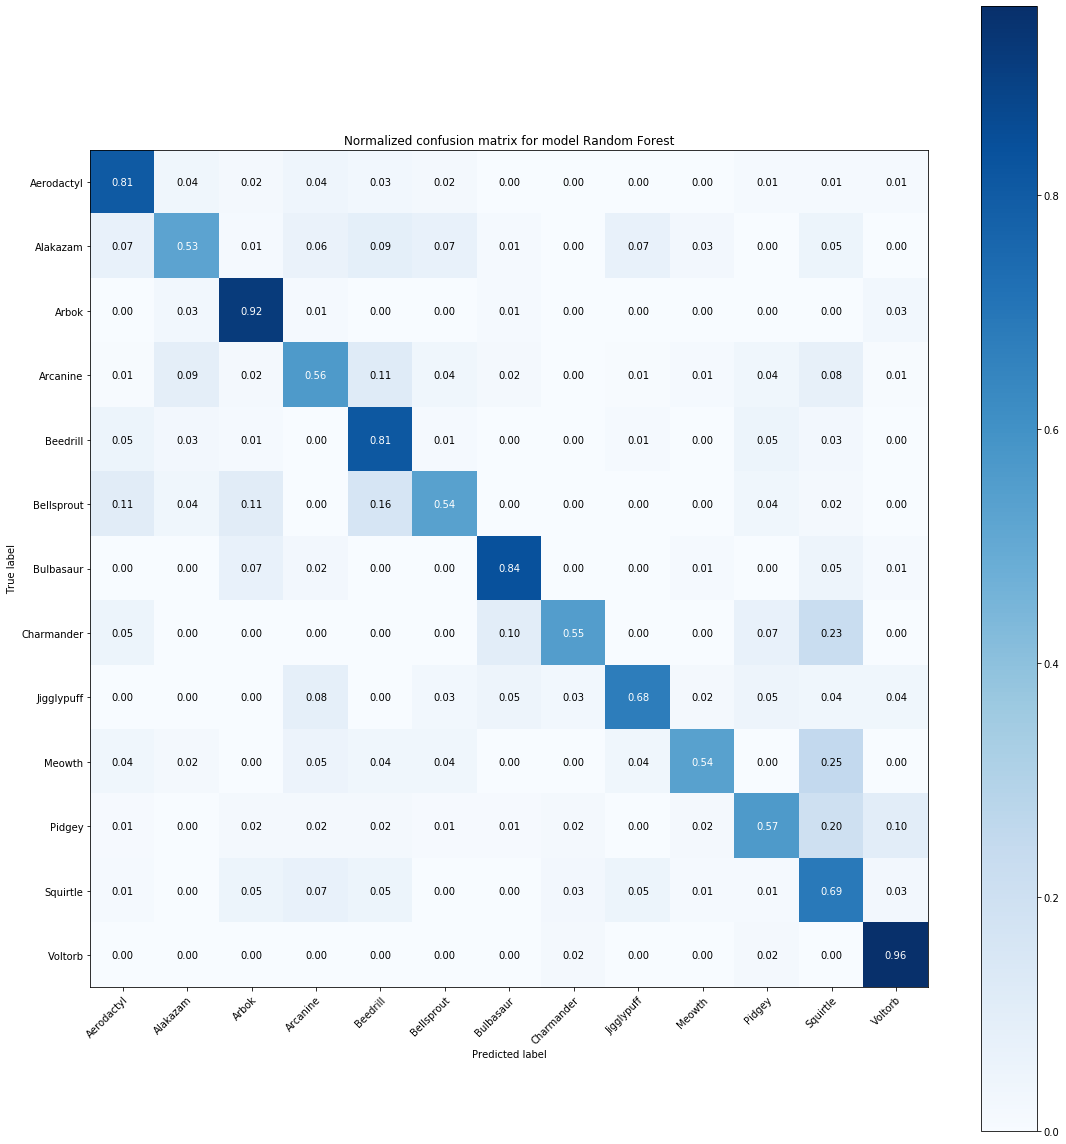

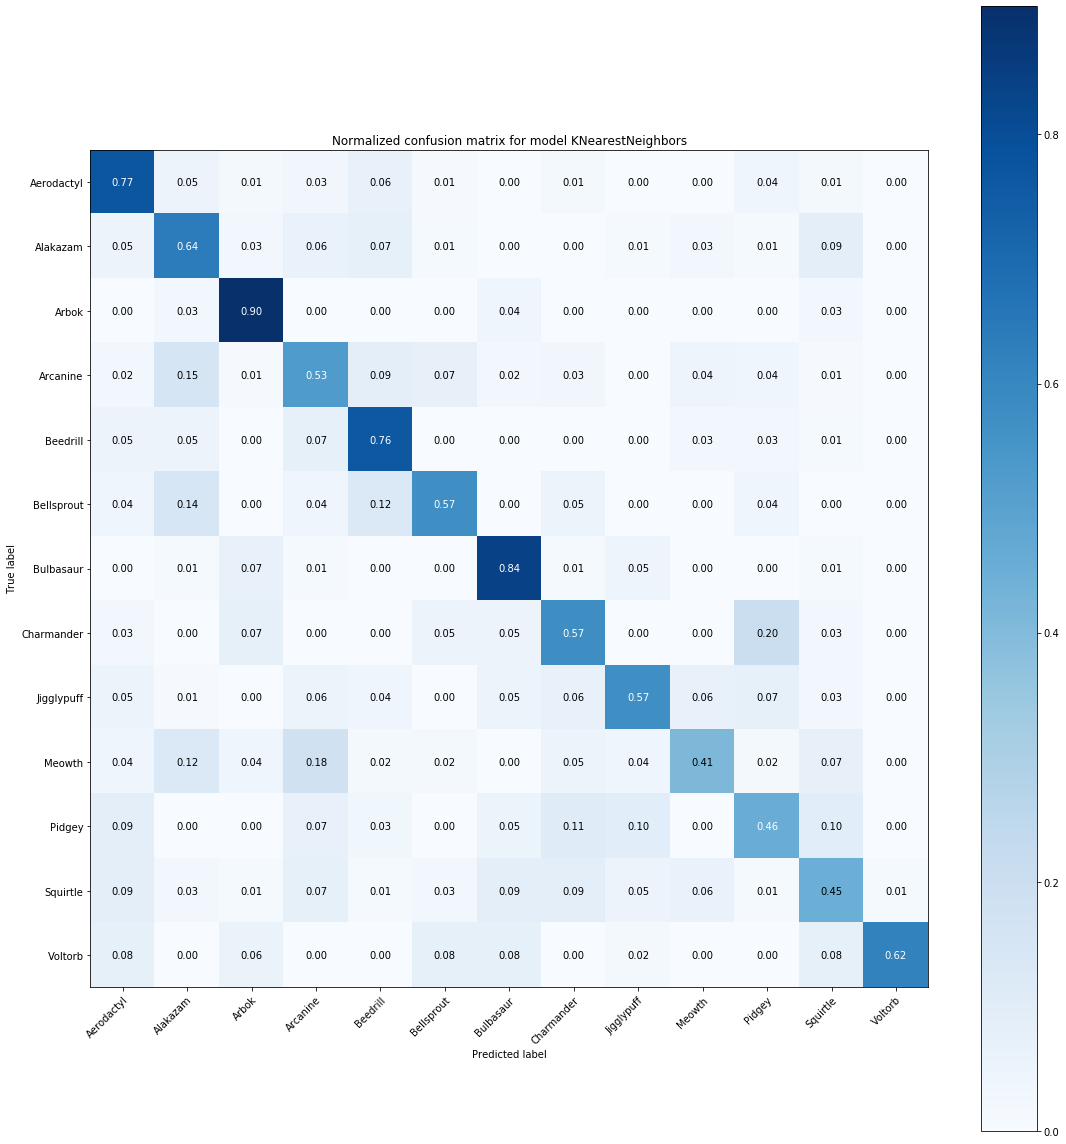

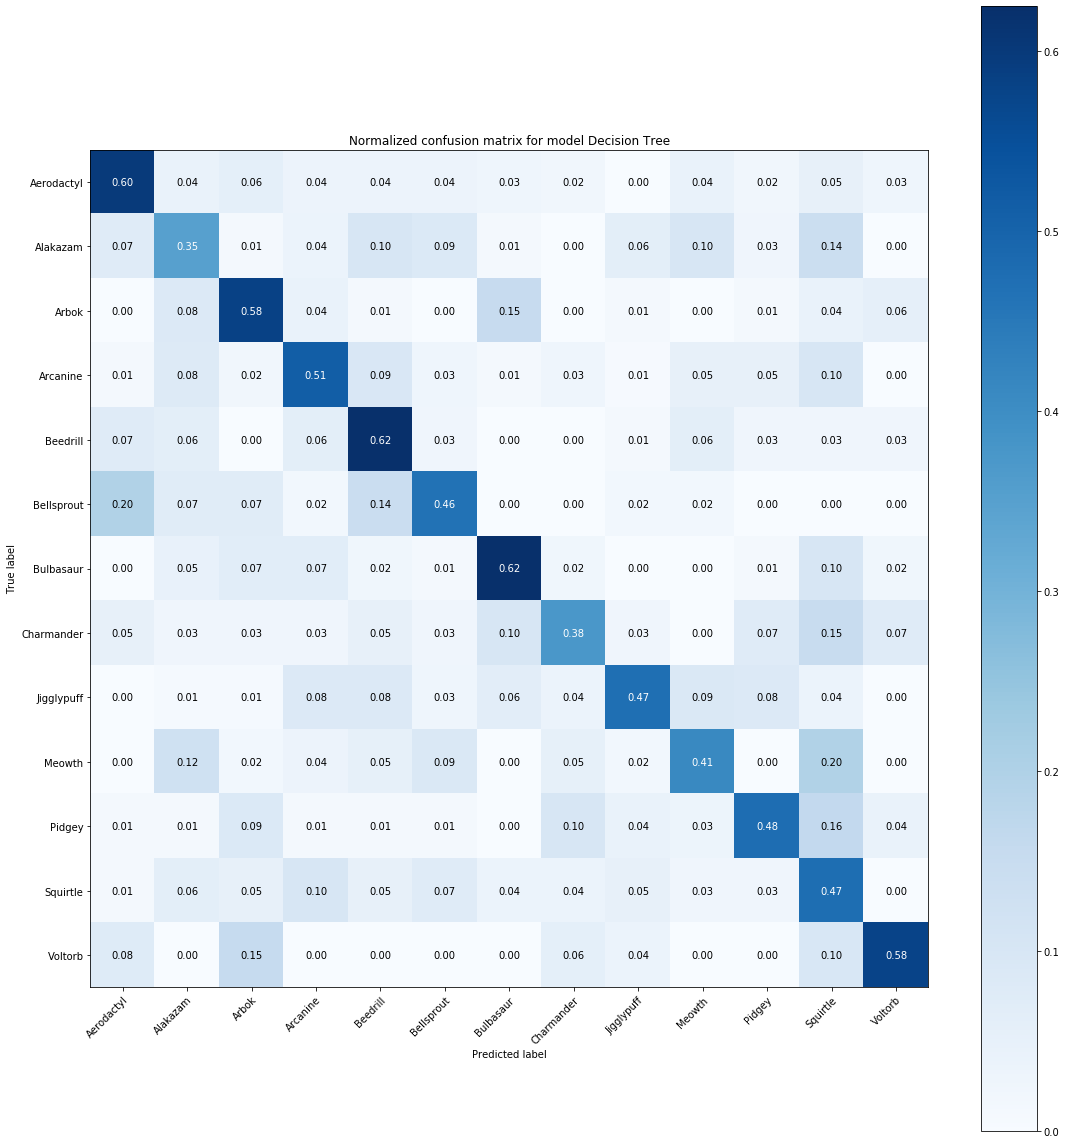

In [55]:
if PLOT_CONFUSION_MATRIXES and FIT_MODELS:
    multi_confusion_mtx(X_test, y_test, models)

In [56]:
if PRECISION_AT_N and FIT_MODELS:
    pprint({model_name: precision_at_n(model) for (model_name, model) in models.items()})

{'Decision Tree': (304, 780, 0.28044280442804426),
 'KNearestNeighbors': (231, 853, 0.21309963099630996),
 'Random Forest': (241, 843, 0.22232472324723246)}


In [59]:
for model_name, model in models.items():
    print("%s score of: %.5f" % (model_name, model.score(X_test, y_test)))

Random Forest score of: 0.69280
KNearestNeighbors score of: 0.63007
Decision Tree score of: 0.51476
